#### The goal of this homework is to super-resolve a very low resolution image (32x32) to a high resolution image (1024x1024) using a trained image prior as discussed in class. The generative prior used here is a style GAN, its code is already provided, and its trained parameters can be downloaded from: https://drive.google.com/uc?id=1TCViX1YpQyRsklTVYEJwdbmK91vklCo8

#### We start by loading the provided high resolution image, then downscaling it by a factor of 32. We then recover the original high resolution image by minimizing equation 3 in the lecture notes using gradient descent.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision

from bicubic import BicubicDownSample  #Downscaler
from stylegan import G_synthesis       #style GAN

torch.Size([1, 3, 1024, 1024])


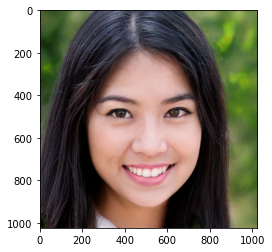

In [2]:
gt = Image.open('gt.jpeg') #load ground truth high resolution img
gt = torchvision.transforms.ToTensor()(gt)
gt = gt.unsqueeze(0)

print(gt.shape)
plt.imshow(gt.squeeze(0).permute(1,2,0))

In [3]:
device = 'cuda'
gt = gt.to(device)

torch.Size([1, 3, 32, 32])


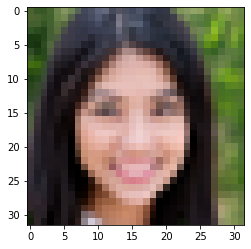

In [4]:
#Downscaling
A = BicubicDownSample(factor=32)
y = A(gt)
y = y.clamp(0,1)

print(y.shape)
plt.imshow(y.cpu().squeeze(0).permute(1,2,0))

In [5]:
#Load trained style GAN
model = G_synthesis().to(device)
state_dict = torch.load('synthesis.pt')  #enter path to the downloaded state_dict
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
#Scaling factors
gaussian_fit = torch.load("gaussian_fit.pt")
lrelu = torch.nn.LeakyReLU(negative_slope=0.2)

In [7]:
#Load noise input to GAN, not that z1 is trainable but z2 is kept fixed.

z1 = torch.randn((1, 18, 512), dtype=torch.float, requires_grad=True, device=device)

#Generate list of noise tensors
z2 = [] # stores all of the noise tensors

for i in range(18):
    # dimension of the ith noise tensor
    res = (1, 1, 2**(i//2+2), 2**(i//2+2))

    new_noise = torch.randn(res, dtype=torch.float, device=device)
    new_noise.requires_grad = False

    z2.append(new_noise)

In [8]:
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#Takes as input noise, and returns an image
def G(z1,z2):
    latent = lrelu(z1*gaussian_fit["std"] + gaussian_fit["mean"])
    img = model(latent, z2) 
    img = (img + 1)/2  
    img = img.clamp(0,1)
    return img 

Write your code to recover the original image by optimizing over $z_1$

In [9]:
train_iter = 200
alpha = 0.1
lamda = 0.00007

optimizer = torch.optim.Adam([z1], lr=alpha)

for i in tqdm(range(train_iter)):
    optimizer.zero_grad()
    img = G(z1,z2)
    loss = mse(A(img),y) + lamda * torch.norm(z1)
    loss.backward()
    optimizer.step()    

Plot your final image here

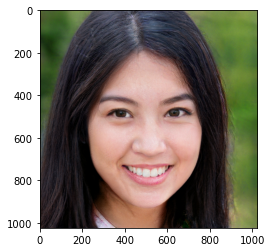

In [10]:
plt.imshow(img.detach().cpu().squeeze(0).permute(1,2,0))

Print the MSE between your final image and the ground truth here

In [11]:
mse(gt,img)

tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)

### Bonus 
As we can see, the final image looks like a high resolution image of a face, but is not very similar to the ground truth. By additionally optimizing over $z_2$ as well, you can get slightly better results.

For achieving very good results, you can use the code from the following gihub repository: https://github.com/krantirk/Self-Supervised-photo